In [1]:
#let's import neccery libraries
import pandas as pd
import numpy as np
import scipy.stats 
import yfinance as yf

import matplotlib.pyplot as plt
import seaborn as sns

### Задание 1

   Дана динамика покупки пользователями платных подписок в мобильном приложении с марта по октябрь 2018 года. 1 октября 2018 года вышла новая версия приложения. С 10.10.18 по 12.10.18 пользователи могли оформить подписку со скидкой.    
**Задача:**    
Необходимо проанализировать рост выручки. Результат оформить в виде краткого отчета с визуализацией данных.

In [2]:
data = pd.read_excel('Data_Analyst (5).xlsx')

In [3]:
data.head()

Date  Revenue ($)
0 2018-03-01      7878261
1 2018-03-02      7995176
2 2018-03-03      9887822
3 2018-03-04     10067265
4 2018-03-05      9018922

In [4]:
data.set_index('Date', inplace=True)

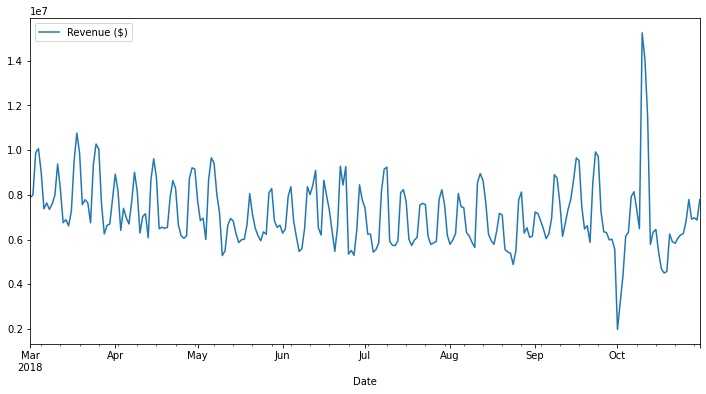

In [5]:
data.plot(figsize=(12,6))

let's analize revenue week to week.

In [6]:
weekly_data =data.resample('W').sum()['2018-03-11':]
weekly_data['Rate']= weekly_data.pct_change()*100

In [433]:
weekly_data.head()

Revenue ($)      Rate
Date                             
2018-03-11     56328677  0.000000
2018-03-18     56070919 -0.457596
2018-03-25     59188052  5.559269
2018-04-01     53896541 -8.940168
2018-04-08     52356721 -2.856992

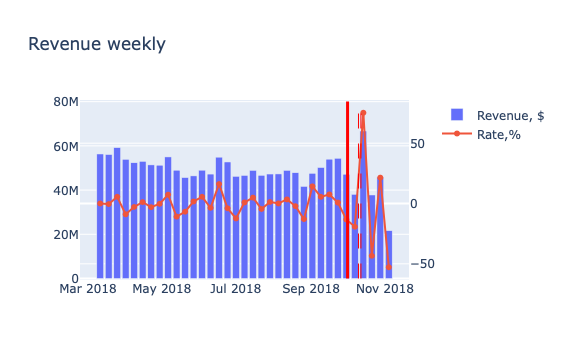

In [432]:
import plotly.express as px
import plotly.offline as pyo
from plotly.subplots import make_subplots
import plotly.graph_objects as go
pyo.init_notebook_mode()
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Bar(    
    x = weekly_data.index,
    y=weekly_data['Revenue ($)'],name = 'Revenue, $'),secondary_y=False)

fig.add_shape(type='line',
                yref="y",
                xref="x",
                x0='2018-10-01',
                y0=0,
                x1='2018-10-01',
                y1=max(weekly_data['Revenue ($)'])*1.2,
                line=dict(color='red', width=3))
fig.add_shape(type='line',
                yref="y",
                xref="x",
                x0='2018-10-10',
                y0=0,
                x1='2018-10-10',
                y1=max(weekly_data['Revenue ($)'])*1.2,
                line=dict(color='red', width=1,dash='longdash'))
fig.add_shape(type='line',
                yref="y",
                xref="x",
                x0='2018-10-12',
                y0=0,
                x1='2018-10-12',
              name = 'Vers',
              visible = True,
                y1=max(weekly_data['Revenue ($)'])*1.2,
                line=dict(color='red', width=1,dash='longdash'))



fig.add_trace(go.Scatter(
    x=weekly_data.index,
    y=weekly_data['Rate'],
    mode='lines+markers',
    name='Rate,%'),
    secondary_y=True,
    exclude_empty_subplots=False
    )
fig.update_layout(title_text='Revenue weekly')
fig.show()

**Revenue is falling after new version. Discounts does not have long term effect unfortunatly.**

## Задание 2

C целью определить лучший баннер в мобильном приложении, тестовой группе
пользователей была предложена версия с другим цветовым решением с одинаковой   
возможность покупки платного функционала.   
A/B-тест был проведен в период с 08.05.19 по 09.05.19.   
**Задача:**     
Необходимо оценить какой из вариантов баннера является более предпочтительным для
пользователей из региона US.

In [45]:
df = pd.read_excel('Data_Analyst (5).xlsx',1,usecols=[0,1,2])

In [46]:
df.dropna(inplace=True)

In [47]:
df.head()

UserID Country    Group
0     1.0      US   Target
1     2.0      EU   Target
3     4.0     SEA   Target
4     5.0      US  Control
5     6.0      EU  Control

In [48]:
revenue_data=pd.read_excel('Data_Analyst (5).xlsx',1,usecols=[5,6,7])

In [49]:
data = revenue_data.merge(df,'inner',left_on='UserID.1',right_on='UserID')

In [50]:
data.head()

UserID.1       Date  Revenue (BYN)  UserID Country   Group
0         2 2019-05-08           47.4     2.0      EU  Target
1         2 2019-05-06           19.8     2.0      EU  Target
2         2 2019-05-10           38.1     2.0      EU  Target
3         2 2019-05-05           31.2     2.0      EU  Target
4         2 2019-05-07           54.3     2.0      EU  Target

In [51]:
data = data[(data['Country']=='US') &(data['Date']>='2019-05-08') & (data['Date']<='2019-05-09')]

In [62]:
data = data.groupby(['UserID','Group'],as_index=False).sum().drop('UserID.1',axis=1)

In [69]:
data.UserID.nunique()==data.shape[0]
#we confirn,that we don't have users who were in both groups 

True

In [79]:
sum(data['Group']=='Target')

4092

In [199]:
required_n= min(sum(data['Group']=='Control'),sum(data['Group']=='Target'))

In [95]:
control_sample = data[data['Group']=='Control'].sample(n=required_n)
treatment_sample = data[data['Group']=='Target'].sample(n=required_n)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)

In [99]:
conversion_rates = ab_test.groupby('Group')['Revenue (BYN)']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

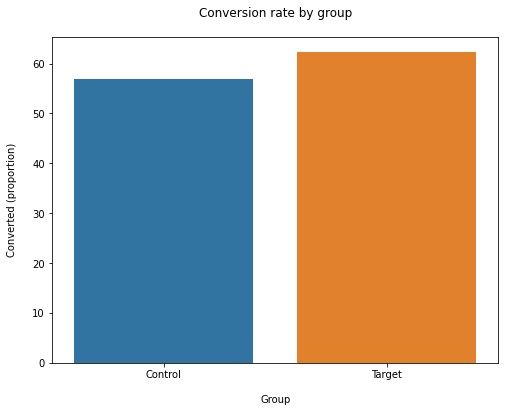

In [101]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['Group'], y=ab_test['Revenue (BYN)'], ci=False)


plt.title('Revenue of groups', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Revenue', labelpad=15);


In [190]:
control_results = ab_test[ab_test['Group']=='Control']['Revenue (BYN)']


treatment_results = ab_test[ab_test['Group']=='Target']['Revenue (BYN)']



control_results = preprocessing.normalize([control_results])

treatment_results=preprocessing.normalize([treatment_results])

In [198]:
stats.ttest_ind(control_results[0], treatment_results[0],nan_policy='omit')

Ttest_indResult(statistic=0.1958665432584308, pvalue=0.8447198364069439)

**p_value>0.05. So we can say that Banner don't have such a good result and I would recommend not to change design of the banner**

## Задание 3

Дана выгрузка данных пользователей в виде когортного анализа. Стоимость подписки,
которую приобретали пользователи мобильного приложения – 9,99$.   
**Задача:**   
Необходимо рассчитать прогнозный LTV24 (сколько нам принесет пользователь на
протяжении 24-х месяцев использования приложения) на основании имеющихся
данных.   
Следует учитывать, что с покупки подписки 30% от стоимости подписки забирает
Apple в первый год, 15% - во второй.   

In [219]:
data = pd.read_excel('Data_Analyst (5).xlsx',2)

In [226]:
data.drop('Active monthly subscribers amount',axis =1,inplace=True)

In [227]:
data.set_index('Date', inplace=True)

Trial  Month 1  Month 2  Month 3  Month 4  Month 5  Month 6  \
Date                                                                      
2017-04-01   1501      711    437.0    286.0    206.0    142.0    116.0   
2017-05-01   1253      544    338.0    246.0    178.0    138.0    109.0   
2017-06-01   1226      522    319.0    228.0    169.0    133.0     99.0   
2017-07-01   1484      538    297.0    201.0    147.0    112.0     85.0   
2017-08-01   2009      775    449.0    317.0    257.0    198.0    170.0   
2017-09-01   2132      940    580.0    384.0    289.0    225.0    177.0   
2017-10-01   1231      467    279.0    196.0    148.0    103.0     84.0   
2017-11-01   1035      392    194.0    128.0    118.0     80.0     65.0   
2017-12-01    511      241    127.0     94.0     87.0     57.0     51.0   
2018-01-01   2167      756    439.0    311.0    244.0    186.0    140.0   
2018-02-01    930      367    210.0    141.0    117.0     78.0     66.0   
2018-03-01   1140      478    249.0    168.0    155.0     91.0     86.0   
2018-04-01    961      413    190.0    144.0    130.0     80.0     70.0   
2018-05-01   1018      400    195.0    144.0    132.0     76.0     74.0   
2018-06-01   1009      336    178.0    116.0    107.0     66.0     59.0   
2018-07-01   5507     1607    898.0    631.0    485.0    367.0    298.0   
2018-08-01  15545     4001   2144.0   1445.0   1063.0    840.0    671.0   
2018-09-01   4504     1498    859.0    588.0    437.0    343.0      NaN   
2018-10-01   7335     1598    865.0    594.0    439.0      NaN      NaN   
2018-11-01   6890     1806    931.0    611.0      NaN      NaN      NaN   
2018-12-01   1425      711    352.0      NaN      NaN      NaN      NaN   
2019-01-01   1793      626      NaN      NaN      NaN      NaN      NaN   

            Month 7  Month 8  Month 9  ...  Month 15  Month 16  Month 17  \
Date                                   ...                                 
2017-04-01     95.0     78.0     65.0  ...      32.0      27.0      21.0   
2017-05-01     89.0     71.0     57.0  ...      21.0      19.0      16.0   
2017-06-01     82.0     72.0     62.0  ...      27.0      26.0      25.0   
2017-07-01     77.0     64.0     56.0  ...      32.0      30.0      23.0   
2017-08-01    148.0    126.0     99.0  ...      51.0      41.0      38.0   
2017-09-01    146.0    125.0    106.0  ...      44.0      39.0      37.0   
2017-10-01     62.0     53.0     47.0  ...      21.0      15.0       NaN   
2017-11-01     65.0     48.0     44.0  ...      20.0       NaN       NaN   
2017-12-01     47.0     33.0     30.0  ...       NaN       NaN       NaN   
2018-01-01    119.0     94.0     81.0  ...       NaN       NaN       NaN   
2018-02-01     65.0     49.0     42.0  ...       NaN       NaN       NaN   
2018-03-01     71.0     55.0     54.0  ...       NaN       NaN       NaN   
2018-04-01     64.0     46.0     45.0  ...       NaN       NaN       NaN   
2018-05-01     70.0     48.0     37.0  ...       NaN       NaN       NaN   
2018-06-01     58.0     36.0      NaN  ...       NaN       NaN       NaN   
2018-07-01    251.0      NaN      NaN  ...       NaN       NaN       NaN   
2018-08-01      NaN      NaN      NaN  ...       NaN       NaN       NaN   
2018-09-01      NaN      NaN      NaN  ...       NaN       NaN       NaN   
2018-10-01      NaN      NaN      NaN  ...       NaN       NaN       NaN   
2018-11-01      NaN      NaN      NaN  ...       NaN       NaN       NaN   
2018-12-01      NaN      NaN      NaN  ...       NaN       NaN       NaN   
2019-01-01      NaN      NaN      NaN  ...       NaN       NaN       NaN   

            Month 18  Month 19  Month 20  Month 21  Month 22  Month 23  \
Date                                                                     
2017-04-01      18.0      15.0      14.0      11.0       9.0       NaN   
2017-05-01      15.0      15.0      13.0      13.0       NaN       NaN   
2017-06-01      23.0      21.0      19.0       NaN       NaN       NaN   
2017-07-01      

In [225]:
from datetime import datetime
data['Date'] = data['Date'].apply(lambda x:np.datetime64(x).astype(datetime))

In [228]:
user_retention = data.div(data['Trial'],axis=0)
user_retention.head()

Trial   Month 1   Month 2   Month 3   Month 4   Month 5   Month 6  \
Date                                                                            
2017-04-01    1.0  0.473684  0.291139  0.190540  0.137242  0.094604  0.077282   
2017-05-01    1.0  0.434158  0.269753  0.196329  0.142059  0.110136  0.086991   
2017-06-01    1.0  0.425775  0.260196  0.185971  0.137847  0.108483  0.080750   
2017-07-01    1.0  0.362534  0.200135  0.135445  0.099057  0.075472  0.057278   
2017-08-01    1.0  0.385764  0.223494  0.157790  0.127924  0.098556  0.084619   

             Month 7   Month 8   Month 9  ...  Month 15  Month 16  Month 17  \
Date                                      ...                                 
2017-04-01  0.063291  0.051965  0.043304  ...  0.021319  0.017988  0.013991   
2017-05-01  0.071030  0.056664  0.045491  ...  0.016760  0.015164  0.012769   
2017-06-01  0.066884  0.058728  0.050571  ...  0.022023  0.021207  0.020392   
2017-07-01  0.051887  0.043127  0.037736  ...  0.021563  0.020216  0.015499   
2017-08-01  0.073668  0.062718  0.049278  ...  0.025386  0.020408  0.018915   

            Month 18  Month 19  Month 20  Month 21  Month 22  Month 23  \
Date                                                                     
2017-04-01  0.011992  0.009993  0.009327  0.007328  0.005996       NaN   
2017-05-01  0.011971  0.011971  0.010375  0.010375       NaN       NaN   
2017-06-01  0.018760  0.017129  0.015498       NaN       NaN       NaN   
2017-07-01  0.013477  0.012129       NaN       NaN       NaN       NaN   
2017-08-01  0.017919       NaN       NaN       NaN       NaN       NaN   

            Month 24  
Date                  
2017-04-01       NaN  
2017-05-01       NaN  
2017-06-01       NaN  
2017-07-01       NaN  
2017-08-01       NaN  

[5 rows x 25 columns]

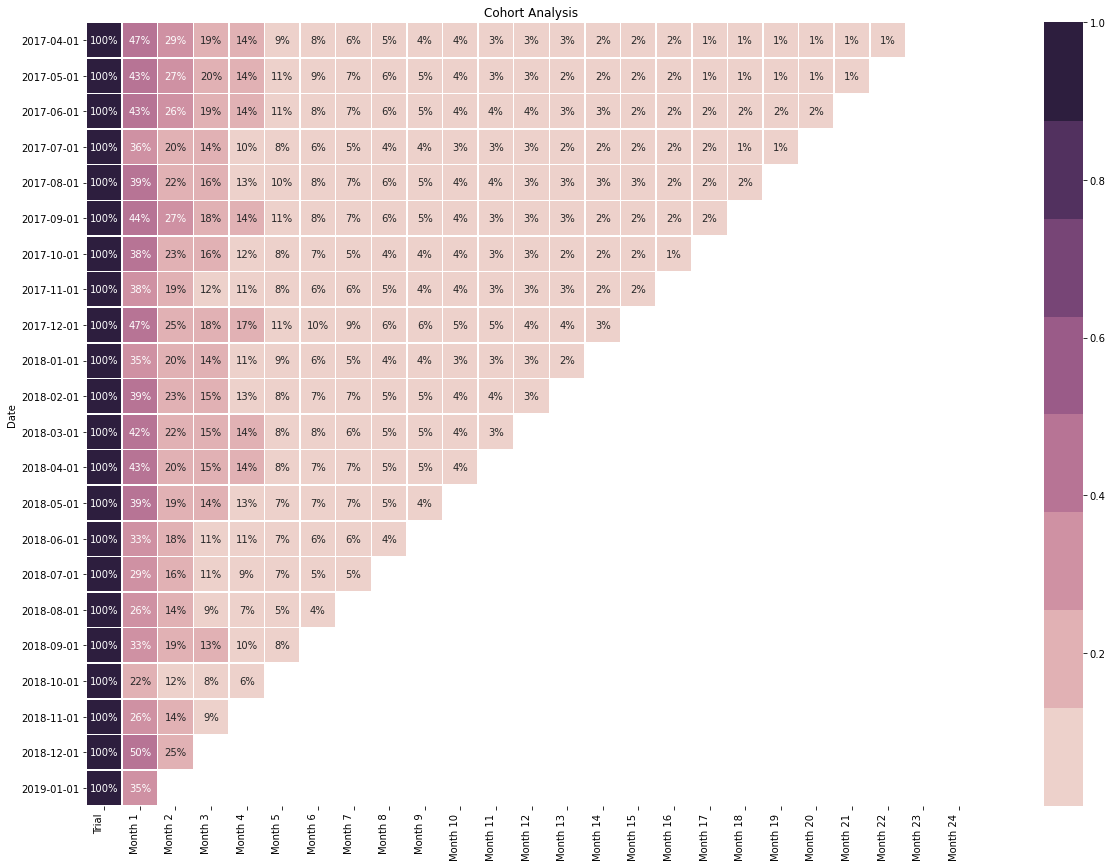

In [233]:
import seaborn as sns
import matplotlib.pyplot as plt
headers = data.index
fig_dims = (24, 16)
fig, ax = plt.subplots(figsize=fig_dims)

fig.autofmt_xdate()
ylabel=user_retention.index
ax.set( title="Cohort Analysis")
sns.heatmap(user_retention, annot=True, fmt='.0%', mask=user_retention.isnull(), ax=ax, square=True, linewidths=.5, cmap=sns.cubehelix_palette(8))

ticklabels = [user_retention.index[int(tick)].strftime('%Y-%m-%d') for tick in ax.get_yticks()]
ax.set_yticklabels(ticklabels);

plt.show()

In [258]:
revenue = (data.iloc[:,:12]*6.99).merge(data.iloc[:,12:]*(9.99*0.85),left_index=True,right_index=True)
revenue.head()

Trial  Month 1  Month 2  Month 3  Month 4  Month 5  Month 6  \
Date                                                                         
2017-04-01  10491.99  4969.89  3054.63  1999.14  1439.94   992.58   810.84   
2017-05-01   8758.47  3802.56  2362.62  1719.54  1244.22   964.62   761.91   
2017-06-01   8569.74  3648.78  2229.81  1593.72  1181.31   929.67   692.01   
2017-07-01  10373.16  3760.62  2076.03  1404.99  1027.53   782.88   594.15   
2017-08-01  14042.91  5417.25  3138.51  2215.83  1796.43  1384.02  1188.30   

            Month 7  Month 8  Month 9  ...  Month 15  Month 16  Month 17  \
Date                                   ...                                 
2017-04-01   664.05   545.22   454.35  ...  271.7280  229.2705  178.3215   
2017-05-01   622.11   496.29   398.43  ...  178.3215  161.3385  135.8640   
2017-06-01   573.18   503.28   433.38  ...  229.2705  220.7790  212.2875   
2017-07-01   538.23   447.36   391.44  ...  271.7280  254.7450  195.3045   
2017-08-01  1034.52   880.74   692.01  ...  433.0665  348.1515  322.6770   

            Month 18  Month 19  Month 20  Month 21  Month 22  Month 23  \
Date                                                                     
2017-04-01  152.8470  127.3725  118.8810   93.4065   76.4235       NaN   
2017-05-01  127.3725  127.3725  110.3895  110.3895       NaN       NaN   
2017-06-01  195.3045  178.3215  161.3385       NaN       NaN       NaN   
2017-07-01  169.8300  152.8470       NaN       NaN       NaN       NaN   
2017-08-01  305.6940       NaN       NaN       NaN       NaN       NaN   

            Month 24  
Date                  
2017-04-01       NaN  
2017-05-01       NaN  
2017-06-01       NaN  
2017-07-01       NaN  
2017-08-01       NaN  

[5 rows x 25 columns]

In [275]:
acc_revenue=pd.DataFrame()
acc_revenue['Trial'] =revenue['Trial']


In [276]:
acc_revenue['Month 1']= revenue['Trial']+revenue['Month 1']

In [277]:
for i in range(2,23):
    name = 'Month '+str(i)
    prev_name = 'Month '+str(i-1)
    acc_revenue[name]= revenue[name]+acc_revenue[prev_name]

In [278]:
acc_revenue

Trial    Month 1    Month 2    Month 3    Month 4    Month 5  \
Date                                                                           
2017-04-01   10491.99   15461.88   18516.51   20515.65   21955.59   22948.17   
2017-05-01    8758.47   12561.03   14923.65   16643.19   17887.41   18852.03   
2017-06-01    8569.74   12218.52   14448.33   16042.05   17223.36   18153.03   
2017-07-01   10373.16   14133.78   16209.81   17614.80   18642.33   19425.21   
2017-08-01   14042.91   19460.16   22598.67   24814.50   26610.93   27994.95   
2017-09-01   14902.68   21473.28   25527.48   28211.64   30231.75   31804.50   
2017-10-01    8604.69   11869.02   13819.23   15189.27   16223.79   16943.76   
2017-11-01    7234.65    9974.73   11330.79   12225.51   13050.33   13609.53   
2017-12-01    3571.89    5256.48    6144.21    6801.27    7409.40    7807.83   
2018-01-01   15147.33   20431.77   23500.38   25674.27   27379.83   28679.97   
2018-02-01    6500.70    9066.03   10533.93   11519.52   12337.35   12882.57   
2018-03-01    7968.60   11309.82   13050.33   14224.65   15308.10   15944.19   
2018-04-01    6717.39    9604.26   10932.36   11938.92   12847.62   13406.82   
2018-05-01    7115.82    9911.82   11274.87   12281.43   13204.11   13735.35   
2018-06-01    7052.91    9401.55   10645.77   11456.61   12204.54   12665.88   
2018-07-01   38493.93   49726.86   56003.88   60414.57   63804.72   66370.05   
2018-08-01  108659.55  136626.54  151613.10  161713.65  169144.02  175015.62   
2018-09-01   31482.96   41953.98   47958.39   52068.51   55123.14   57520.71   
2018-10-01   51271.65   62441.67   68488.02   72640.08   75708.69        NaN   
2018-11-01   48161.10   60785.04   67292.73   71563.62        NaN        NaN   
2018-12-01    9960.75   14930.64   17391.12        NaN        NaN        NaN   
2019-01-01   12533.07   16908.81        NaN        NaN        NaN        NaN   

              Month 6   Month 7   Month 8   Month 9  ...    Month 13  \
Date                                                 ...               
2017-04-01   23759.01  24423.06  24968.28  25422.63  ...  26869.8660   
2017-05-01   19613.94  20236.05  20732.34  21130.77  ...  22323.3120   
2017-06-01   18845.04  19418.22  19921.50  20354.88  ...  21764.1630   
2017-07-01   20019.36  20557.59  21004.95  21396.39  ...  22723.7610   
2017-08-01   29183.25  30217.77  31098.51  31790.52  ...  34005.3075   
2017-09-01   33041.73  34062.27  34936.02  35676.96  ...  37790.3670   
2017-10-01   17530.92  17964.30  18334.77  18663.30  ...  19751.4585   
2017-11-01   14063.88  14518.23  14853.75  15161.31  ...  16209.0300   
2017-12-01    8164.32   8492.85   8723.52   8933.22  ...   9653.3430   
2018-01-01   29658.57  30490.38  31147.44  31713.63  ...  33579.8505   
2018-02-01   13343.91  13798.26  14140.77  14434.35  ...         NaN   
2018-03-01   16545.33  17041.62  17426.07  17803.53  ...         NaN   
2018-04-01   13896.12  14343.48  14665.02  14979.57  ...         NaN   
2018-05-01   14252.61  14741.91  15077.43  15336.06  ...         NaN   
2018-06-01   13078.29  13483.71  13735.35       NaN  ...         NaN   
2018-07-01   68453.07  70207.56       NaN       NaN  ...         NaN   
2018-08-01  179705.91       NaN       NaN       NaN  ...         NaN   
2018-09-01        NaN       NaN       NaN       NaN  ...         NaN   
2018-10-01        NaN       NaN       NaN       NaN  ...         NaN   
2018-11-01        NaN       NaN       NaN       NaN  ...         NaN   
2018-12-01        NaN       NaN       NaN       NaN  ...         NaN   
2019-01-01        NaN       NaN       NaN       NaN  ...         NaN   

              Month 14    Month 15    Month 16    Month 17   Month 18  \
Date                                                                    
2017-04-01  27175.5600  27447.2880  27676.5585  27854.8800  28007.727   
2017-05-01  22552.5825  22730.9040  22892.2425  23028.1065  23155.479   
2017-06-01  22061.3655  22290.6360  22511.4150  22723.7025  22919.007   
2

In [284]:
ltv_frame = pd.DataFrame()
for i in acc_revenue.columns:
    ltv_frame[i] = acc_revenue[i]/data['Trial']

Text(0.5, 1.0, 'LTV')

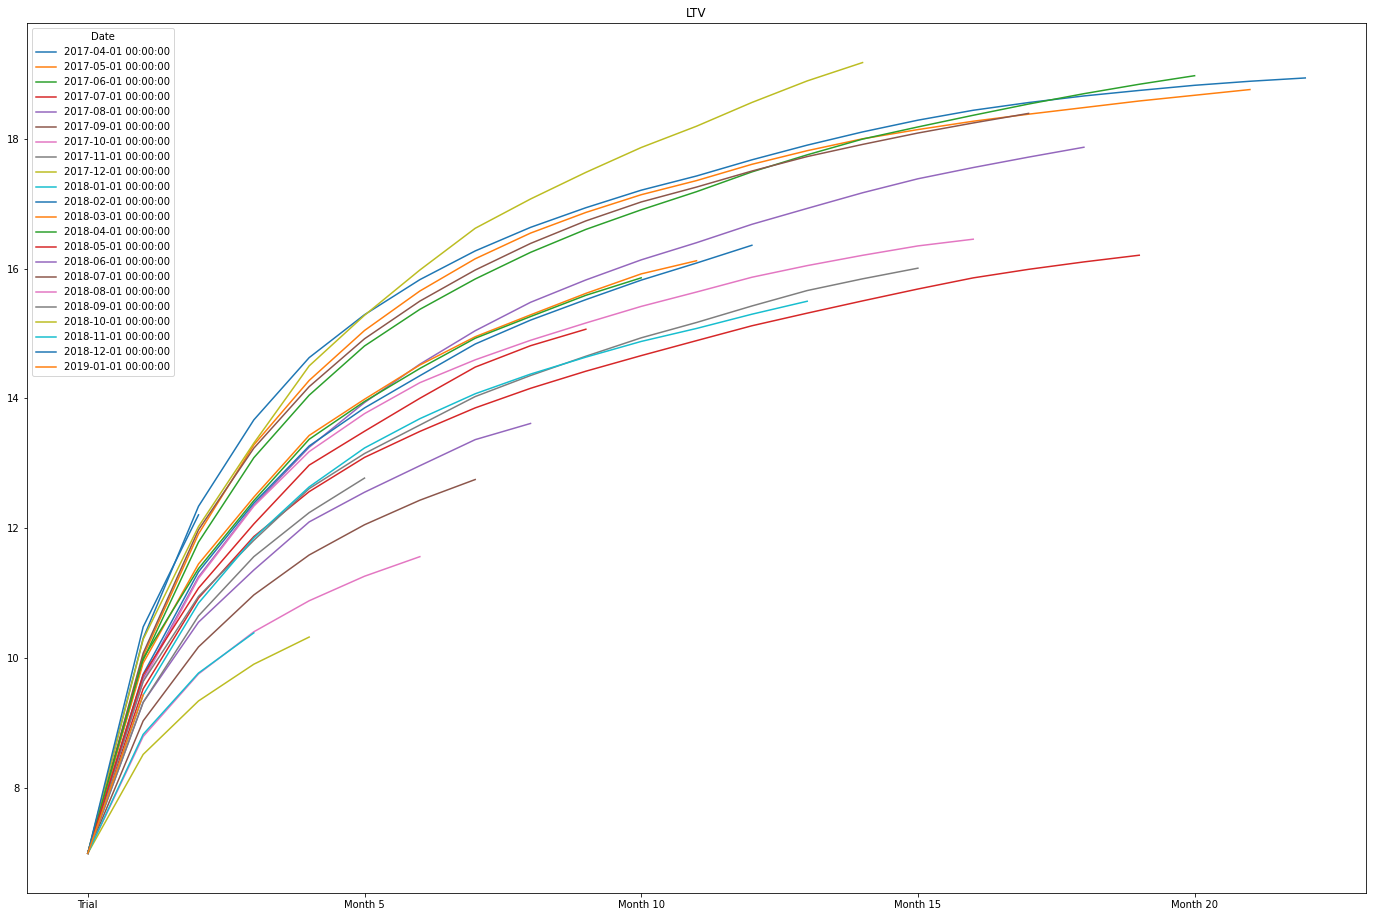

In [303]:
fig_dims = (24, 16)
ltv_frame.transpose().plot(figsize = fig_dims)
plt.title('LTV')

As far as I understand LTV-metric. We should approximate the first cohort.
Let's do it.

In [342]:
#we want to find out degree of freedom 
m = 9223372036854775807
deg = 0
for i in range(1,10):
    coefficients =np.polyfit (y = ltv_frame.iloc[0,:],x = range(23),deg = i) 
    p = np.poly1d(coefficients)
    mnk_val = mnk(ltv_frame.iloc[0,:],p(ltv_frame.iloc[0,:]))
    if mnk(ltv_frame.iloc[0,:],p(ltv_frame.iloc[0,:]))<m:
        m = mnk_val
        deg = i
print(m,deg)
    


176.38461279128776 1


In [343]:
LTV24 = p(24)

In [344]:
print(LTV24)

18.594018068358203
